## Importing the necesarry libraries

In [ ]:
import os  # For interacting with the file system (creating folders, handling paths)
import cv2  # OpenCV for video processing and optical flow computation
import numpy as np  # For array operations
import matplotlib.pyplot as plt  # To visualize optical flow
from glob import glob  # To list files with patterns (like all .mp4 files)
from tqdm import tqdm  # For progress bars (not used here but useful for loops)
from sklearn.model_selection import train_test_split  # To split data for training/testing
import tensorflow as tf  # Main deep learning framework used here
from tensorflow.keras.models import Sequential  # Model architecture class
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense  # Layers used in our model
from tensorflow.keras.callbacks import EarlyStopping  # To prevent overfitting by stopping early

## Parameters

In [ ]:
# ------------------------------
# Approach: Define global parameters for frame and flow dimensions
# Effect: Keeps the code modular and easily tunable
# ------------------------------
FRAME_SIZE = 128  # Resize input frames to 128x128 for uniform input shape
FLOW_SIZE = 64    # Resize optical flow maps to 64x64 for reducing computation
SEQ_LENGTH = 10   # Use a sequence of 10 optical flow vectors per video for temporal modeling

## Frame Extraction

In [ ]:
# ------------------------------
# Approach: Extract fixed number of resized frames from video
# Impact: Standardizes input data for consistent downstream processing
# ------------------------------
def extract_frames(video_path, output_folder, max_frames=20):
    os.makedirs(output_folder, exist_ok=True)  # Create directory if it doesn't exist
    cap = cv2.VideoCapture(video_path)  # Load the video
    count = 0
    while count < max_frames:
        ret, frame = cap.read()  # Read frame-by-frame
        if not ret:
            break  # Stop if video ends
        frame = cv2.resize(frame, (FRAME_SIZE, FRAME_SIZE))  # Resize to standard size
        cv2.imwrite(os.path.join(output_folder, f"frame_{count:03d}.jpg"), frame)  # Save each frame
        count += 1
    cap.release()  # Release the video capture object

## Optical Flow Extraction + Normalization

In [ ]:
# ------------------------------
# Approach: Compute dense optical flow between consecutive frames and normalize
# Impact: Captures motion information; normalization improves training stability
# ------------------------------
def compute_optical_flow(input_folder):
    frames = sorted(glob(f"{input_folder}/frame_*.jpg"))  # Get all frames in order
    flow_sequence = []  # List to store optical flow results
    for i in range(len(frames)-1):
        img1 = cv2.imread(frames[i])  # Read first frame
        img2 = cv2.imread(frames[i+1])  # Read second frame
        if img1 is None or img2 is None:
            continue
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 
                                            0.5, 3, 15, 3, 5, 1.2, 0)  # Compute dense optical flow
        flow = cv2.resize(flow, (FLOW_SIZE, FLOW_SIZE))  # Resize for consistent input shape
        flow = np.clip(flow / 20.0, -1, 1)  # Normalize flow vectors to range [-1, 1]
        flow_sequence.append(flow)  # Append flow to sequence

    if len(flow_sequence) < SEQ_LENGTH:
        return None  # Skip if not enough flow frames
    return np.array(flow_sequence[:SEQ_LENGTH])  # Return the first SEQ_LENGTH flow frames

## Visualize Optical Flow

In [ ]:
# ------------------------------
# Approach: Visualize flow fields to qualitatively validate motion patterns
# Impact: Helpful for debugging and verifying correctness of preprocessing
# ------------------------------
def visualize_flow(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  # Convert to polar coords (magnitude and angle)
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue corresponds to direction
    hsv[..., 1] = 255  # Full saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Brightness corresponds to magnitude
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)  # Convert to RGB for display
    plt.imshow(rgb)
    plt.title("Optical Flow Visualization")
    plt.axis('off')
    plt.show()

## Data Preprocessing

In [ ]:
# ------------------------------
# Approach: Loop through real/fake video datasets, extract optical flow sequences
# Impact: Builds dataset of temporal features (optical flow) for training
# ------------------------------
X = []  # Feature list
y = []  # Label list

# Loop through both real and fake classes
for label, paths in zip([0, 1], [glob("data/real_videos/*.mp4"), glob("data/fake_videos/*.mp4")]):
    for i, video_path in enumerate(paths):
        tag = "real" if label == 0 else "fake"  # Tag name based on class
        output_folder = f"data/extracted_frames/{tag}_{i}"  # Folder to save frames
        extract_frames(video_path, output_folder)  # Step 1: Extract frames from video
        flow_seq = compute_optical_flow(output_folder)  # Step 2: Compute optical flow
        if flow_seq is not None:
            X.append(flow_seq)  # Add flow sequence
            y.append(label)  # Add label (0 or 1)

X = np.array(X)  # Convert to numpy array for model input
y = np.array(y)
print(f"Data loaded: X={X.shape}, y={y.shape}")

## Train/Test Split &  Build the Model

In [27]:
# ------------------------------
# Approach: Stratified train-test split to preserve class distribution
# Impact: Ensures model generalizes across balanced classes
# ------------------------------
if X.shape[0] == 0:
    print("No valid data found for training.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42  # Stratify ensures equal distribution of labels
    )
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")

    # ------------------------------
    # Approach: Use CNN to extract spatial features + LSTM to capture temporal patterns
    # Impact: Combines spatial and temporal modeling for deepfake detection
    # ------------------------------
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQ_LENGTH, FLOW_SIZE, FLOW_SIZE, 2)),  # 2 channels for flow x & y
        TimeDistributed(MaxPooling2D((2, 2))),  # Downsample the features
        TimeDistributed(Flatten()),  # Flatten spatial data to feed into LSTM
        LSTM(64, return_sequences=False),  # Capture sequence-level motion patterns
        Dense(32, activation='relu'),  # Dense layer to learn higher-level representations
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compile the model with loss and metric
    model.summary()  # Print model architecture

    # ------------------------------
    # Approach: Train model with early stopping on validation loss
    # Impact: Prevents overfitting and saves best model automatically
    # ------------------------------
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Stop training if no improvement for 3 epochs
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),  # Evaluate on test data every epoch
        epochs=20,  # Max number of epochs
        batch_size=8,  # Batch size (tune for speed/performance tradeoff)
        callbacks=[early_stop]  # Add early stopping
    )

    # ------------------------------
    # Approach: Evaluate trained model on test data
    # Impact: Measures generalization and provides accuracy metric
    # ------------------------------
    loss, acc = model.evaluate(X_test, y_test)  # Final evaluation on unseen test data
    print(f"Test Accuracy: {acc:.4f}")  # Print the result

Data loaded: X=(400, 10, 64, 64, 2), y=(400,)
Train: (320, 10, 64, 64, 2), Test: (80, 10, 64, 64, 2)


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_14                  │ (None, 10, 62, 62, 32)      │             608 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 10, 31, 31, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 10, 30752)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │       7,889,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,891,873 (30.11 MB)

 Trainable params: 7,891,873 (30.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 933ms/step - accuracy: 0.7929 - loss: 0.5524 - val_accuracy: 0.8125 - val_loss: 0.4881
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 756ms/step - accuracy: 0.7906 - loss: 0.5113 - val_accuracy: 0.8125 - val_loss: 0.4919
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 718ms/step - accuracy: 0.8125 - loss: 0.4761 - val_accuracy: 0.8125 - val_loss: 0.4904
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 679ms/step - accuracy: 0.7984 - loss: 0.5102 - val_accuracy: 0.8125 - val_loss: 0.5181
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.8125 - loss: 0.4861
Test Accuracy: 0.8125


## Visualize and Save Optical Flow as sample_output.png

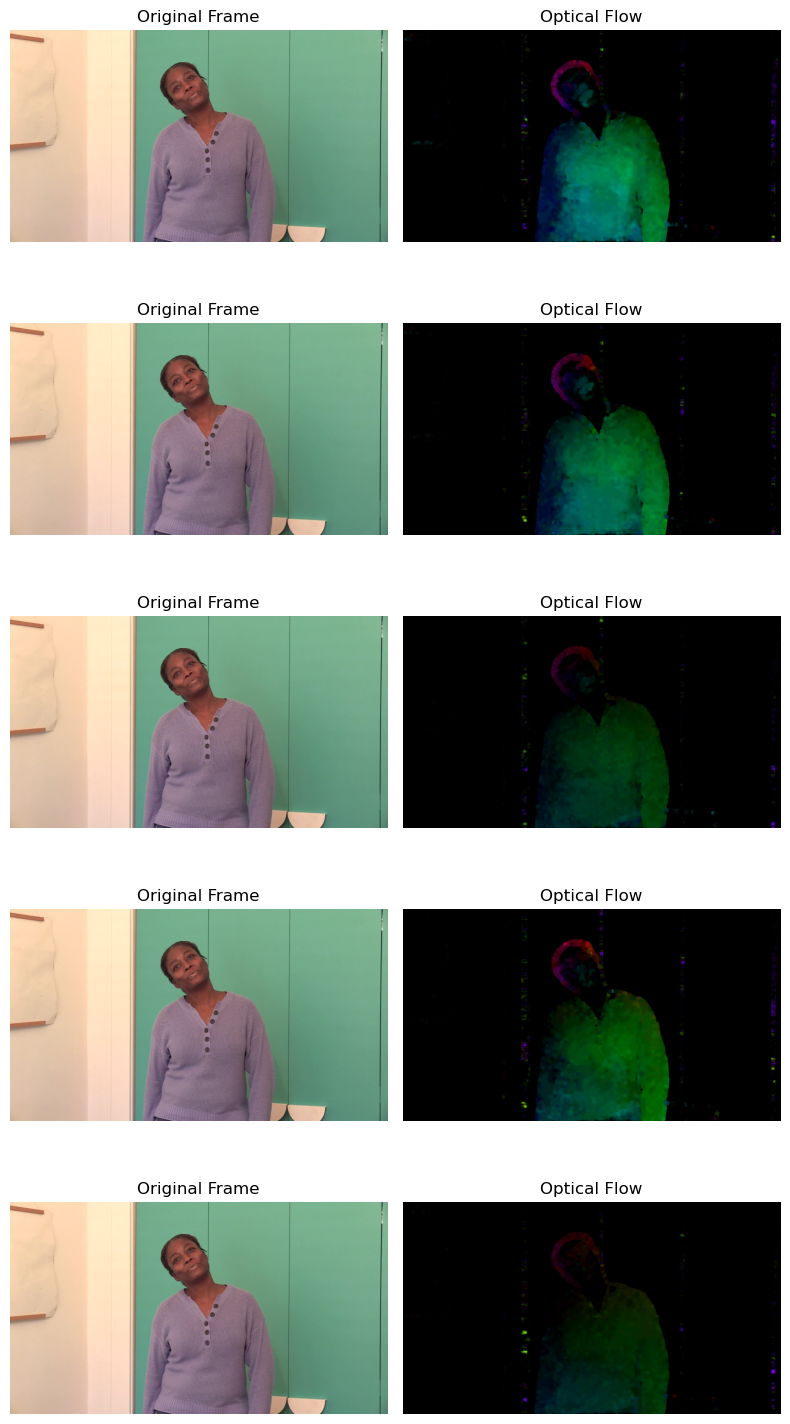

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_optical_flow(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    fig, axes = plt.subplots(num_frames, 2, figsize=(8, num_frames * 3))
    frame_count = 0

    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Calculate dense optical flow
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                            0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv = np.zeros_like(frame)
        hsv[..., 1] = 255
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # Plot original frame and optical flow
        axes[frame_count, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[frame_count, 0].set_title("Original Frame")
        axes[frame_count, 0].axis("off")

        axes[frame_count, 1].imshow(flow_rgb)
        axes[frame_count, 1].set_title("Optical Flow")
        axes[frame_count, 1].axis("off")

        prev_gray = gray
        frame_count += 1

    plt.tight_layout()
    plt.savefig("sample_output.png")
    plt.show()
    cap.release()

# Example usage — change the path to one of your real/fake videos
draw_optical_flow("data/real_videos/abarnvbtwb.mp4")
